## Imports

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## Extracting Data

In [3]:
DATA_DIR = Path().resolve().parent / "data" 
print(DATA_DIR)
with open(DATA_DIR / 'stock_data.json', 'r') as file:
    # Load the data from the file
    nested_data = json.load(file)

/home/boran/Desktop/financial-ETL/data


In [41]:
aapl_data = nested_data[1]['AAPL']

# Initialize a DataFrame
df = pd.DataFrame()

# Flatten each key and create columns
for key, nested_dict in aapl_data.items():
    flattened = pd.DataFrame.from_dict(nested_dict, orient='index', columns=[key])
    df = pd.concat([df, flattened], axis=1)

In [42]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/25/2024,$232.87,90152830,$231.46,$233.245,$229.74
1,11/22/2024,$229.87,38168250,$228.06,$230.7199,$228.06
2,11/21/2024,$228.52,42108330,$228.88,$230.155,$225.7103
3,11/20/2024,$229.00,35169570,$228.06,$229.93,$225.89
4,11/19/2024,$228.28,36211770,$226.98,$230.16,$226.66


## Transform

In [43]:
df.rename(columns={
    "Close/Last":"Close"
}, inplace=True)

columns_to_clean = ['Close', 'Open', 'High', 'Low']
df[columns_to_clean] = df[columns_to_clean].replace({r'\$': ''}, regex=True).astype(float)

numeric_columns = ["Close", "Volume", "Open", "High", "Low"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

df.sort_index(ascending=True, inplace=True)

df = df.asfreq("D")
df.ffill(inplace=True)
df.index

DatetimeIndex(['2014-11-26', '2014-11-27', '2014-11-28', '2014-11-29',
               '2014-11-30', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05',
               ...
               '2024-11-16', '2024-11-17', '2024-11-18', '2024-11-19',
               '2024-11-20', '2024-11-21', '2024-11-22', '2024-11-23',
               '2024-11-24', '2024-11-25'],
              dtype='datetime64[ns]', name='Date', length=3653, freq='D')

In [44]:
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2014-11-26,29.7500,163027800.0,29.4850,29.775,29.4575
2014-11-27,29.7500,163027800.0,29.4850,29.775,29.4575
2014-11-28,29.7325,99257600.0,29.8175,29.850,29.5125
2014-11-29,29.7325,99257600.0,29.8175,29.850,29.5125
2014-11-30,29.7325,99257600.0,29.8175,29.850,29.5125


In [45]:
df.tail()

,Close,Volume,Open,High,Low
Date,,,,,
2024-11-21,228.52,42108330.0,228.88,230.1550,225.7103
2024-11-22,229.87,38168250.0,228.06,230.7199,228.0600
2024-11-23,229.87,38168250.0,228.06,230.7199,228.0600
2024-11-24,229.87,38168250.0,228.06,230.7199,228.0600
2024-11-25,232.87,90152830.0,231.46,233.2450,229.7400


## Exploratory Data Analysis

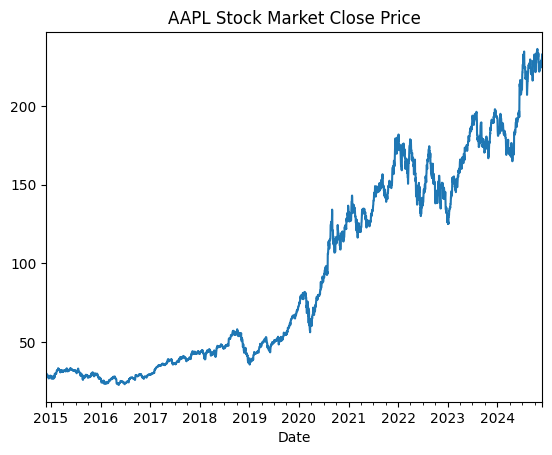

In [46]:
df['Close'].plot(title = 'AAPL Stock Market Close Price')
plt.show()

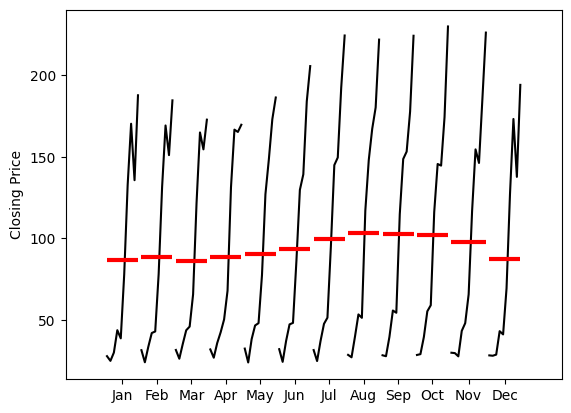

In [47]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of the complaint values
month_plot(df['Close'].resample('ME').mean(),
           ylabel = 'Closing Price')
plt.show()

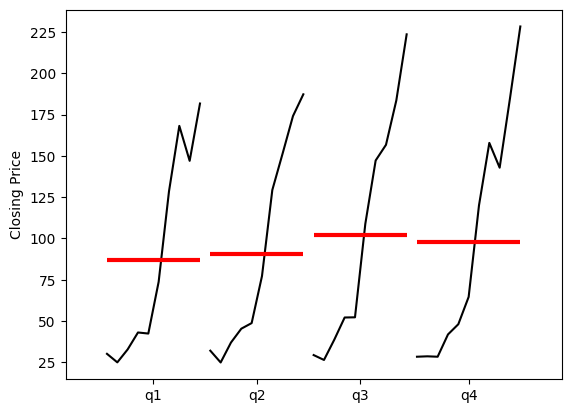

In [48]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of the complaint values
quarter_plot(df['Close'].resample('QE').mean(),
           ylabel = 'Closing Price')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

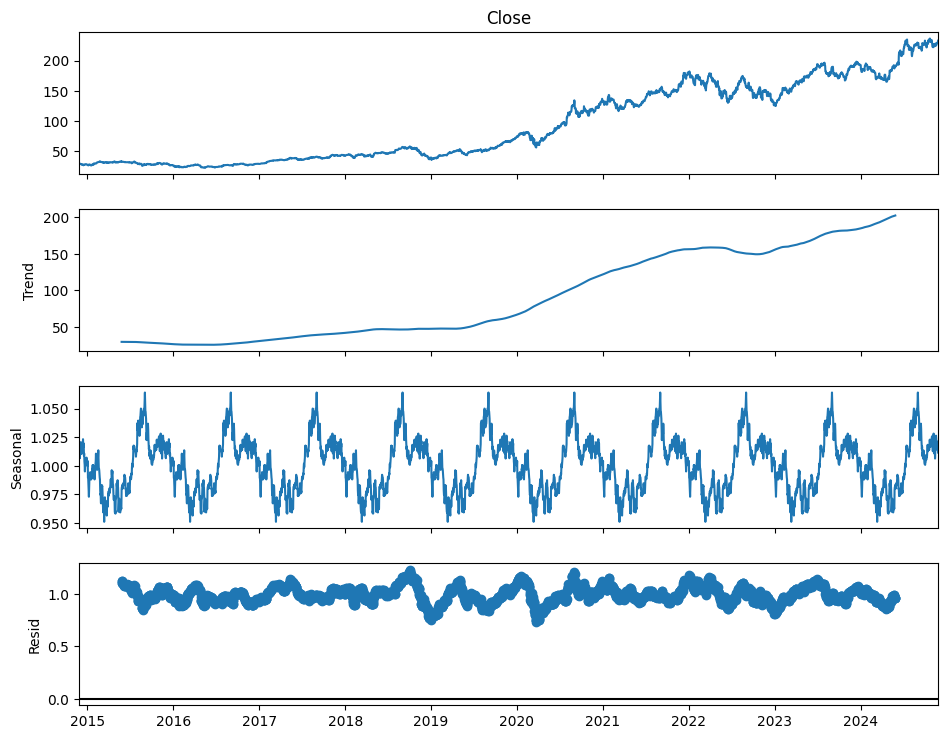

In [49]:
# Seasonal Decomposition Plots for closing price values
# Multiplicative model type, with yearly seasonality (52 weeks)
decomposition = seasonal_decompose(df['Close'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.

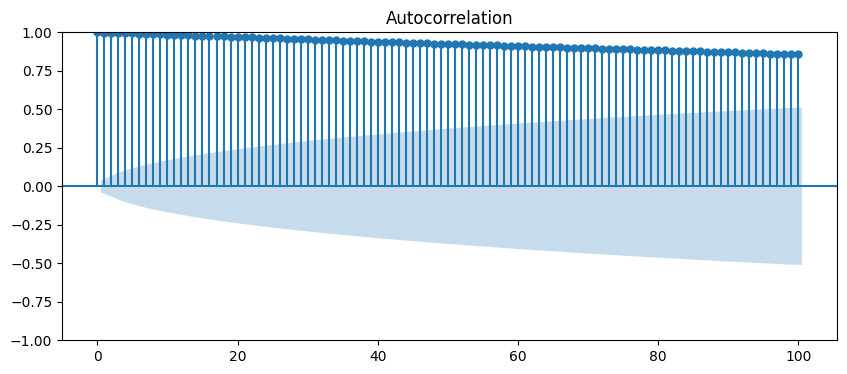

In [26]:
# Plot the autocorrelation (ACF) of complaint values
fig, ax = plt.subplots(figsize = (10,4))
plot_acf(df['Close'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

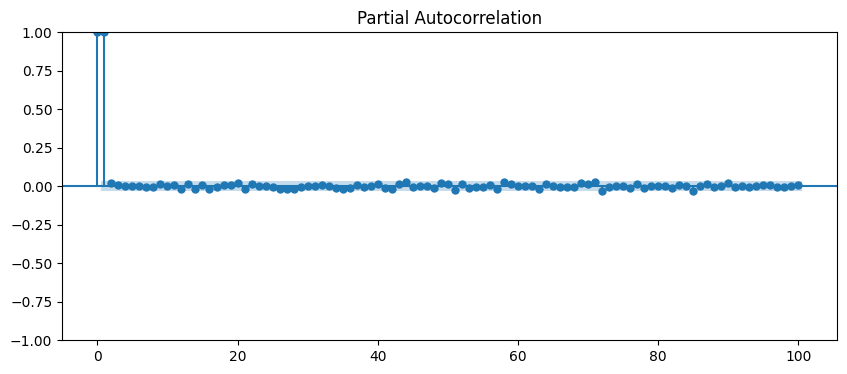

In [50]:
# Plot the partial autocorrelation (PACF) of complaint values
fig, ax = plt.subplots(figsize = (10,4))
plot_pacf(df['Close'], lags = 100, ax = ax)
plt.show()

## Pre-processing

### Test and Training Split

In [51]:
# Training and Test Split
# Train: all data except last n periods of the column 'complaints'
# Test: last n periods of the column 'complaints'
# Test with 6 months
periods = 6*30
train, test = df.iloc[:-periods,0], df.iloc[-periods:, 0 ]
test.head()

Date
2024-05-30    191.29
2024-05-31    192.25
2024-06-01    192.25
2024-06-02    192.25
2024-06-03    194.03
Freq: D, Name: Close, dtype: float64

## Triple Exponential Smoothing (Holt-Winters method)

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, extends Double Exponential Smoothing by adding a seasonal component to handle data with seasonal patterns in addition to trends.

Key Features:
- Seasonality Handling - Triple Exponential Smoothing accommodates time series data with seasonal patterns, which can be daily, weekly, monthly, quarterly, or annual.
- Components - It involves three components: level (smoothed value), trend, and seasonal.

In [52]:
# Triple Exponential Smoothing Model
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 365 (daily data with yearly seasonality)

model_triple = ExponentialSmoothing(train,
                                    trend = 'add',
                                    seasonal = "mul",
                                    seasonal_periods = 365).fit()

/home/boran/Desktop/financial-ETL/financial-venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [59]:
print(model_triple.mle_retvals)

 message: Iteration limit reached
 success: False
  status: 9
     fun: 7331.548980150601
       x: [ 9.595e-01  1.593e-04 ...  1.221e+00  1.212e+00]
     nit: 100
     jac: [-3.210e+03  4.836e+03 ...  2.573e+02  2.667e+01]
    nfev: 37595
    njev: 100


In [53]:
# Use the fitted Triple Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set. (30 days)
predictions_triple = model_triple.forecast(len(test))
predictions_triple

2024-05-30    189.867258
2024-05-31    191.061058
2024-06-01    192.794748
2024-06-02    190.248720
2024-06-03    190.669033
                 ...    
2024-11-21    190.538062
2024-11-22    189.804854
2024-11-23    189.425961
2024-11-24    188.853101
2024-11-25    187.617489
Freq: D, Length: 180, dtype: float64

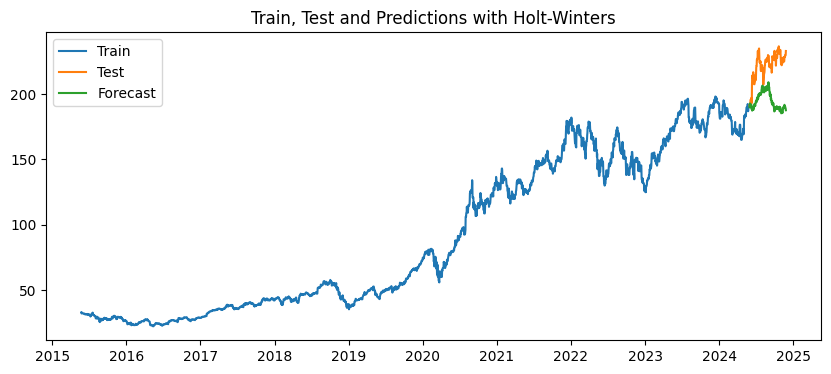

The MAE is 27.17
The RMSE is 871.10
The MAPE is 12.07 %


In [57]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Call the model_assessment function with the specified arguments
model_assessment(train[periods:], test, predictions_triple, "Holt-Winters")

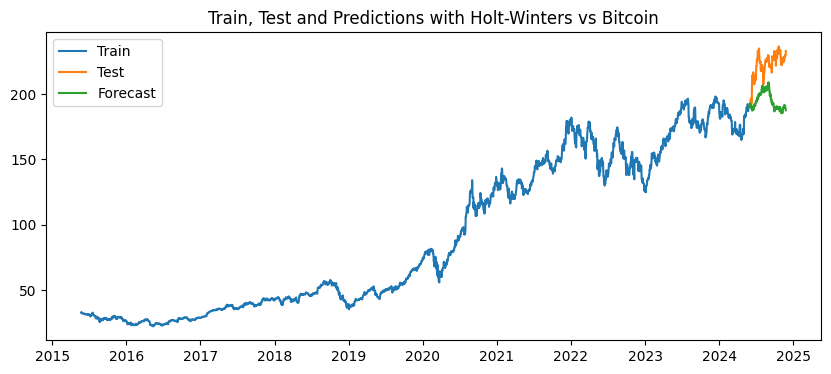

The MAE is 27.17
The RMSE is 871.10
The MAPE is 12.07 %


In [58]:
# Model Assessment
# Assess the performance of the model
# using test data starting from November 2023, comparing its predictions to the actual values of Bitcoin prices.
model_assessment(train[periods:], test, predictions_triple, "Holt-Winters vs Bitcoin")